In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
#pd.set_option('display.max_rows', 50)
df = pd.read_csv("DataChallenge_GBDentalClaims.csv")

seed = 0
from sklearn.model_selection import train_test_split
data, test = train_test_split(df, test_size=0.2, random_state=seed)
train, val = train_test_split(data, test_size=0.25, random_state=seed)

train.reset_index(inplace=True)
val.reset_index(inplace=True)
test.reset_index(inplace=True)

X_train, y_train = train[[col for col in train.columns if col != 'sum_paid_amt_after_cob']], train[['sum_paid_amt_after_cob']]
X_val, y_val = val[[col for col in val.columns if col != 'sum_paid_amt_after_cob']], val[['sum_paid_amt_after_cob']]
X_test, y_test = test[[col for col in test.columns if col != 'sum_paid_amt_after_cob']], test[['sum_paid_amt_after_cob']]

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()


In [25]:
y_test = y_test.values.ravel()

## 1. EDA

In [3]:
corr = train.corr()['sum_paid_amt_after_cob']
corr.sort_values(ascending=False).head(50)

sum_paid_amt                               1.000000
sum_paid_amt_after_cob                     1.000000
sum_adj_amt                                0.992580
sum_paid_amt_cldld                         0.969358
sum_paid_amt_dep                           0.842713
sum_paid_amt_after_cob_dep                 0.842713
sum_adj_amt_dep                            0.838248
sum_paid_amt_cldld_dep                     0.805515
num_claims                                 0.775554
sum_charge_amt                             0.770152
total_num_serv_lines                       0.747740
sum_dent_chrg_amt_dep                      0.678762
sum_charge_amt_dep                         0.660111
num_claims_dep                             0.649355
total_num_serv_lines_dep                   0.625203
amt_paid_after_cob_restorations            0.552618
num_claims_restorations                    0.546782
prior1yr_sum_paid_amt_after_cob            0.502752
num_claims_recall_exam                     0.496842
prior1yr_tot

we need to exclude columns that cause data leakage for the prediction model

In [4]:
leakage_columns = [   
    'num_claims'
  , 'total_num_serv_lines'
  , 'sum_charge_amt'
  , 'sum_paid_amt'
  , 'sum_adj_amt'
  , 'sum_paid_amt_cldld'
  , 'sum_lab_chrg_amt'
  , 'num_claims_dep'
  , 'total_num_serv_lines_dep'
  , 'sum_charge_amt_dep'
  , 'sum_paid_amt_dep'
  , 'sum_adj_amt_dep'
  , 'sum_paid_amt_cldld_dep'
  , 'sum_paid_amt_after_cob_dep'
  , 'sum_dent_chrg_amt_dep'
  , 'sum_lab_chrg_amt_dep'
  , 'num_claims_exam'
  , 'num_claims_scaling'
  , 'num_claims_crowns'
  , 'num_claims_restorations'
  , 'num_claims_endodontic'
  , 'num_claims_extractions'
  , 'num_claims_polish'
  , 'num_claims_bridgework'
  , 'num_claims_root_planing'
  , 'num_claims_orthodontic'
  , 'num_claims_dentures'
  , 'num_claims_anesthesia'
  , 'num_claims_recall_exam'
  , 'num_claims_xray'
  , 'num_claims_bruxism_appliance'
  , 'num_claims_denturist_services'
  , 'amt_paid_after_cob_exam'
  , 'amt_paid_after_cob_scaling'
  , 'amt_paid_after_cob_crowns'
  , 'amt_paid_after_cob_restorations'
  , 'amt_paid_after_cob_endodontic'
  , 'amt_paid_after_cob_extractions'
  , 'amt_paid_after_cob_polish'
  , 'amt_paid_after_cob_bridgework'
  , 'amt_paid_after_cob_root_planing'
  , 'amt_paid_after_cob_orthodontic'
  , 'amt_paid_after_cob_dentures'
  , 'amt_paid_after_cob_anesthesia'
  , 'amt_paid_after_cob_recall_exam'
  , 'amt_paid_after_cob_xray'
  , 'amt_paid_after_cob_bruxism_appliance'
  , 'amt_paid_after_cob_denturist_services'
]

uninformative_columns = [
  'ee_id', 'member_id'#, 'policy number'
]

X_train = X_train.loc[:, [i for i in X_train.columns if i not in leakage_columns and i not in uninformative_columns] ]
X_val = X_val.loc[:, [i for i in X_val.columns if i not in leakage_columns and i not in uninformative_columns] ]
X_test = X_test.loc[:, [i for i in X_test.columns if i not in leakage_columns and i not in uninformative_columns] ]

X_train

,index,policy number,language,gender,pol_renewal_dt,days_exposure_dental,ftr_employee_age_as_of_renewal,ftr_employee_spouse_age_as_of_renewal,ftr_employee_son_age_as_of_renewal,ftr_employee_daughter_age_as_of_renewal,...,ftr_env_pct_household_2person,ftr_env_pct_household_3person,ftr_env_pct_household_4person,ftr_env_pct_household_5person,pol_renewal_yr,ftr_years_since_cert_effective,ftr_age_at_renewal,MARKET_SEGMENT_ADJ,industry,province
0,1469,23515,E,M,2018-01-01,187,56.0,56.0,NaN,NaN,...,0.388060,0.104478,0.059701,0.000000,2018,0.169863,55.632877,SUNSOLUTIONS,manufacturing,unknown
1,4427,87275,E,M,2019-01-01,365,35.0,35.0,NaN,11.0,...,NaN,NaN,NaN,NaN,2019,0.252055,34.939726,NATIONAL ACCOUNTS,manufacturing,ontario
2,64,4967,E,F,2019-02-01,365,39.0,42.0,7.0,9.0,...,0.342857,0.228571,0.171429,0.028571,2019,1.419178,38.326027,SUNADVANTAGE,service_repair_business,illinois
3,131,5956,E,F,2019-01-01,365,37.0,47.0,6.0,NaN,...,0.344828,0.206897,0.172414,0.103448,2019,7.709589,36.060274,SUNSOLUTIONS,service_repair_business,alberta
4,5640,150005,E,M,2017-07-01,365,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017,0.915068,24.720548,SUNSOLUTIONS,finance_insurance_real_estate,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,4171,83361,E,F,2019-11-01,366,29.0,NaN,NaN,NaN,...,0.263158,0.105263,0.105263,0.000000,2019,1.142466,29.564384,NATIONAL ACCOUNTS,service_repair_business,ontario
4796,179,11501,F,F,2019-01-01,365,83.0,NaN,NaN,NaN,...,0.363636,0.090909,0.000000,0.000000,2019,20.684932,82.956164,NATIONAL ACCOUNTS,finance_insurance_real_estate,ontario
4797,3972,75554,E,M,2018-03-01,365,46.0,NaN,NaN,NaN,...,0.500000,0.166667,0.166667,0.166667,2018,15.010959,45.756164,SUNADVANTAGE,service_repair_business,british_columbia
4798,3555,55311,E,M,2018-01-01,365,44.0,38.0,NaN,19.0,...,0.666667,0.166667,0.083333,0.000000,2018,11.630137,43.134247,NATIONAL ACCOUNTS,manufacturing,ontario


Let's explore the columns a bit

In [5]:
# number of 0 values in columns
dict(X_train[X_train == 0].notna().sum().sort_values(ascending=False))

{'prior2yr_num_claims_orthodontic': 4800,
 'ftr_employee_number_deaths_recorded_household': 4800,
 'prior2yr_num_claims_denturist_services': 4800,
 'prior3yr_num_claims_denturist_services': 4800,
 'prior2yr_amt_paid_after_cob_orthodontic': 4800,
 'prior1yr_num_claims_denturist_services': 4800,
 'prior2yr_amt_paid_after_cob_denturist_services': 4800,
 'prior1yr_amt_paid_after_cob_denturist_services': 4800,
 'prior1yr_amt_paid_after_cob_orthodontic': 4800,
 'prior3yr_amt_paid_after_cob_denturist_services': 4800,
 'prior3yr_amt_paid_after_cob_anesthesia': 4799,
 'prior3yr_amt_paid_after_cob_orthodontic': 4799,
 'prior1yr_num_claims_orthodontic': 4799,
 'prior2yr_num_claims_anesthesia': 4799,
 'prior2yr_amt_paid_after_cob_anesthesia': 4799,
 'prior3yr_num_claims_orthodontic': 4798,
 'ftr_employee_number_handicap_household': 4798,
 'prior3yr_num_claims_anesthesia': 4797,
 'prior1yr_amt_paid_after_cob_anesthesia': 4796,
 'prior2yr_num_claims_dentures': 4795,
 'prior3yr_amt_paid_after_cob_den

Excluding the columns where more than 95% of their values are 0

In [6]:
zero_pct = dict(X_train[X_train == 0].notna().sum() * 100/len(X_train))
high_zero_count_columns = [ i for i in zero_pct if zero_pct[i] > 95 ]
X_train = X_train[ [i for i in X_train.columns if i not in high_zero_count_columns] ]
X_val = X_val[ [i for i in X_val.columns if i not in high_zero_count_columns] ]
X_test = X_test[ [i for i in X_test.columns if i not in high_zero_count_columns] ]

### Transforming columns that contain Null value

In [7]:
# number of null values in columns
null_counts = X_train.isna().sum().sort_values(ascending=False)
null_counts[ null_counts > 0 ]

ftr_employee_daughter_age_as_of_renewal       3744
ftr_employee_son_age_as_of_renewal            3726
ftr_employee_spouse_age_as_of_renewal         2433
cde_marital_status_eeeb                       2239
ftr_employee_days_since_last_salary_change    2239
ftr_employee_amt_sal                          2239
ftr_employee_retire_flag                      2239
ftr_policy_num_retire                         1299
ftr_policy_pct_retire                         1299
ftr_policy_median_salary                      1299
ftr_employee_age_as_of_renewal                 610
ftr_employee_female_presence_flag              598
ftr_employee_male_presence_flag                598
ftr_employee_handicap_presence_flag            598
ftr_employee_student_presence_flag             598
ftr_employee_children_dependent_flag           598
ftr_employee_spouse_dependent_flag             598
ftr_env_pct_owned                              434
ftr_env_med_household_income                   434
ftr_env_avg_household_size     

In [8]:
# number of unique values in columns that contain null
columns_with_null = list(null_counts[ null_counts > 0 ].index)
X_train[ columns_with_null ].nunique().sort_values()

ftr_employee_children_dependent_flag             2
ftr_employee_spouse_dependent_flag               2
ftr_employee_student_presence_flag               2
cde_marital_status_eeeb                          2
ftr_employee_handicap_presence_flag              2
ftr_employee_male_presence_flag                  2
ftr_employee_retire_flag                         2
ftr_employee_female_presence_flag                2
MARKET_SEGMENT_ADJ                               4
ftr_employee_son_age_as_of_renewal              46
ftr_employee_daughter_age_as_of_renewal         48
ftr_employee_spouse_age_as_of_renewal           73
ftr_employee_age_as_of_renewal                  84
ftr_policy_num_retire                           84
ftr_policy_pct_retire                          260
ftr_env_total_households                       652
ftr_env_total_population                       857
ftr_employee_days_since_last_salary_change     912
ftr_env_pct_household_5person                  990
ftr_env_pct_household_3person  

In [9]:
# finding non-numeric columns that contain null values
X_train[ [ col for col in columns_with_null if X_train.dtypes[col] == 'object' ] ].columns

Index(['cde_marital_status_eeeb', 'MARKET_SEGMENT_ADJ'], dtype='object')

In [10]:
# cde_marital_status_eeeb has values 'S' (single), 'M' (married) and Null. 
# we replace null with 0.5 because later we transform this column by replacing 'S' with 0 and 'M' with 1. So it makes sense to set unknown values (nulls) to 0.5
X_train.fillna({'cde_marital_status_eeeb': 0.5}, inplace=True)
X_val.fillna({'cde_marital_status_eeeb': 0.5}, inplace=True)
X_test.fillna({'cde_marital_status_eeeb': 0.5}, inplace=True)

In [11]:
# we replace the rest of null values with the mean of their column
imp_mean = SimpleImputer()

for col in columns_with_null:
  if col not in ['MARKET_SEGMENT_ADJ', 'cde_marital_status_eeeb']:
    X_train[col] = imp_mean.fit_transform(X_train[[col]])
    X_val[col] = imp_mean.transform(X_val[[col]])
    X_test[col] = imp_mean.transform(X_test[[col]])

### Handling non-numerical Columns

In [12]:
# although 'policy number' column contains numbers, but it is in fact categorical because the order of policy numbers doesn't matter
from category_encoders import TargetEncoder
encoder = TargetEncoder(cols=['policy number'])

X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

C:\Users\vahid\AppData\Roaming\Python\Python310\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\vahid\AppData\Roaming\Python\Python310\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [13]:
# non-numerical columns
non_numerical_data = X_train[[ i for i in X_train.columns if X_train.dtypes[i] == 'object' ]]
non_numerical_data

,language,gender,pol_renewal_dt,cde_marital_status_eeeb,MARKET_SEGMENT_ADJ,industry,province
0,E,M,2018-01-01,M,SUNSOLUTIONS,manufacturing,unknown
1,E,M,2019-01-01,M,NATIONAL ACCOUNTS,manufacturing,ontario
2,E,F,2019-02-01,M,SUNADVANTAGE,service_repair_business,illinois
3,E,F,2019-01-01,M,SUNSOLUTIONS,service_repair_business,alberta
4,E,M,2017-07-01,S,SUNSOLUTIONS,finance_insurance_real_estate,unknown
...,...,...,...,...,...,...,...
4795,E,F,2019-11-01,S,NATIONAL ACCOUNTS,service_repair_business,ontario
4796,F,F,2019-01-01,S,NATIONAL ACCOUNTS,finance_insurance_real_estate,ontario
4797,E,M,2018-03-01,S,SUNADVANTAGE,service_repair_business,british_columbia
4798,E,M,2018-01-01,M,NATIONAL ACCOUNTS,manufacturing,ontario


In [14]:
non_numerical_data.nunique().sort_values()

language                    2
gender                      3
cde_marital_status_eeeb     3
MARKET_SEGMENT_ADJ          4
industry                   16
pol_renewal_dt             33
province                   35
dtype: int64

In [15]:
for col in non_numerical_data.columns:
  print(col, non_numerical_data[col].unique())

language ['E' 'F']
gender ['M' 'F' 'U']
pol_renewal_dt ['2018-01-01' '2019-01-01' '2019-02-01' '2017-07-01' '2017-06-01'
 '2017-11-01' '2017-09-01' '2018-09-01' '2018-03-01' '2019-10-01'
 '2017-04-01' '2018-02-01' '2017-08-01' '2018-06-01' '2019-09-01'
 '2018-08-01' '2019-07-01' '2017-10-01' '2019-11-01' '2018-12-01'
 '2018-05-01' '2018-07-01' '2019-04-01' '2017-12-01' '2019-03-01'
 '2018-10-01' '2019-08-01' '2019-12-01' '2019-05-01' '2018-11-01'
 '2018-04-01' '2017-05-01' '2019-06-01']
cde_marital_status_eeeb ['M' 'S' 0.5]
MARKET_SEGMENT_ADJ ['SUNSOLUTIONS' 'NATIONAL ACCOUNTS' 'SUNADVANTAGE'
 'SPONSORED MARKETS - Association' nan]
industry ['manufacturing' 'service_repair_business' 'finance_insurance_real_estate'
 'agriculture' 'oil_industry' 'educational_services'
 'non_profit_service_health' 'automotive' 'public_service_government'
 'retail_trade' 'wholesale_trade'
 'transportation_communication_public_utilities' 'unknown' 'mining'
 'hospital' 'construction']
province ['unknown' 'on

##### `pol_renewal_dt` column

In [16]:
# extracting month from pol_renewal_dt column as a new feature and dropping the original column
X_train['pol_renewal_month'] = X_train['pol_renewal_dt'].str.slice(5, 7).astype(int)
X_train.drop('pol_renewal_dt', axis=1, inplace=True)

X_val['pol_renewal_month'] = X_val['pol_renewal_dt'].str.slice(5, 7).astype(int)
X_val.drop('pol_renewal_dt', axis=1, inplace=True)

X_test['pol_renewal_month'] = X_test['pol_renewal_dt'].str.slice(5, 7).astype(int)
X_test.drop('pol_renewal_dt', axis=1, inplace=True)

##### `cde_marital_status_eeeb` column

In [17]:
# replacing S and M values in cde_marital_status_eeeb with 0 and 1, because there is an inherent order (married people pay more as they have a spouse and probably children)
print(data.groupby('cde_marital_status_eeeb', dropna=False)['sum_paid_amt_after_cob'].agg('mean').sort_values())

X_train.replace({'cde_marital_status_eeeb':{'S':0, 'M': 1}}, inplace=True)
X_val.replace({'cde_marital_status_eeeb':{'S':0, 'M': 1}}, inplace=True)
X_test.replace({'cde_marital_status_eeeb':{'S':0, 'M': 1}}, inplace=True)

cde_marital_status_eeeb
S      374.849123
NaN    579.188597
M      981.727370
Name: sum_paid_amt_after_cob, dtype: float64


##### one-hot encoding the rest of the columns

In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(min_frequency=100, handle_unknown='infrequent_if_exist')
one_hot_X_train_array = encoder.fit_transform(X_train[['province', 'language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry']]).toarray()
one_hot_X_train_df = pd.DataFrame( one_hot_X_train_array, columns=encoder.get_feature_names_out(['province', 'language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry']) )
X_train.drop(['language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry', 'province'], axis=1, inplace=True)
X_train = X_train.join(one_hot_X_train_df)

one_hot_X_val_array = encoder.transform(X_val[['province', 'language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry']]).toarray()
one_hot_X_val_df = pd.DataFrame( one_hot_X_val_array, columns=encoder.get_feature_names_out(['province', 'language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry']) )
X_val.drop(['language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry', 'province'], axis=1, inplace=True)
X_val = X_val.join(one_hot_X_val_df)

one_hot_X_test_array = encoder.transform(X_test[['province', 'language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry']]).toarray()
one_hot_X_test_df = pd.DataFrame( one_hot_X_test_array, columns=encoder.get_feature_names_out(['province', 'language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry']) )
X_test.drop(['language', 'gender', 'MARKET_SEGMENT_ADJ', 'industry', 'province'], axis=1, inplace=True)
X_test = X_test.join(one_hot_X_test_df)

## 2. Model Building

In [19]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# calculating forecast error on the training set (in-sample forecast)
for model in [Lasso(random_state=seed), 
              ElasticNet(random_state=seed), 
              Ridge(random_state=seed), 
              # SVR(kernel='linear'), 
              # SVR(kernel='rbf'), 
              RandomForestRegressor(random_state=seed), 
              XGBRegressor(random_state=seed)]:
  model.fit(X_train, y_train)
  preds = model.predict(X_train)

  print(model)
  print('in-sample forecast error (absolute): {}%'.format(round(abs(y_train - preds).sum() * 100 / y_train.sum(), 2)))
  print('in-sample forecast error (aggregate): {}%'.format(round((y_train - preds).sum() * 100 / y_train.sum(), 2)))
  print()

Lasso(random_state=0)
in-sample forecast error (absolute): 71.41%
in-sample forecast error (aggregate): 0.0%

ElasticNet(random_state=0)
in-sample forecast error (absolute): 71.89%
in-sample forecast error (aggregate): 0.0%

Ridge(random_state=0)
in-sample forecast error (absolute): 71.46%
in-sample forecast error (aggregate): 0.0%

RandomForestRegressor(random_state=0)
in-sample forecast error (absolute): 26.75%
in-sample forecast error (aggregate): -1.52%

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weig

The error for in-sample prediction is still fairly high (17%). We need to see whether the issue is from the model or the data 

In [20]:
import math
from tqdm import tqdm_notebook as tqdm
best_lr, best_deviation = None, math.inf

for lr in tqdm(np.arange(.05, 2, .05)):
  model = XGBRegressor(random_state=seed, learning_rate=lr)
  model.fit(X_train, y_train)
  preds = model.predict(X_train)

  deviation = abs(y_train - preds).sum()
  if deviation < best_deviation:
    best_deviation = deviation
    best_lr = lr

print('best in-sample forecast error (absolute): {}%'.format(round(best_deviation * 100 / y_train.sum(), 2)), 'with learning rate of {}'.format(best_lr))

C:\Users\vahid\AppData\Local\Temp/ipykernel_16976/3477178591.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm(np.arange(.05, 2, .05)):


  0%|          | 0/39 [00:00<?, ?it/s]

best in-sample forecast error (absolute): 2.72% with learning rate of 1.3


This shows that the data is good enough to explain the variation for in-sample forecast.  

Now let's see how the model performs on out-of-sample data (validsation dataset)

In [23]:
model = XGBRegressor(random_state=seed)
model.fit(X_train, y_train)
preds = model.predict(X_val)
deviation = abs(y_val - preds).sum()

print('out-of-sample forecast error (absolute): {}%'.format(round(deviation * 100 / y_val.sum(), 2)))
print('out-of-sample forecast error (aggregate): {}%'.format(round(abs((y_val - preds).sum()) * 100 / y_val.sum(), 2)))

out-of-sample forecast error (absolute): 82.36%
out-of-sample forecast error (aggregate): 4.99%


#### The forecast error on validation dataset is fairly high. We can improve it by doing the following steps
- Explore what types of records the model is struggling with the most
- Further data cleanup and transformations
- Obtain domain knowledge and do Feature Engineering
- Consider other factors that affect the target column and expand the dataset (e.g. location data of the clients (city) )
- Parameter Tuning
- Try different model architectures (e.g. TimeSeries)

#### Parameter tuning

In [22]:
params_dict = {
    'learning_rate':[.015] #np.arange(0.01, 0.02, .002)  # [0.015] 
    , 'max_depth':[11]   
    , 'n_estimators':[110]
    #, 'gamma':range(0, 1500, 200)
    , 'min_child_weight':np.arange(0, 2, .5)
    , 'subsample':np.arange(0, 1, .1)
    ,'base_score' : [0.1, 0.5, 1]
    #, 'objective':['reg:squarederror', 'reg:gamma', 'reg:tweedie']
    #, 'booster':['gbtree', 'gblinear', 'dart']
    #, 'scale_pos_weight' : np.arange(.9, 1.1, .02) # default is best
    #, 'max_delta_step':[0, 10, 100]  # constant

    ,'reg_alpha': [2000, 2500, 3000] #np.arange(0, 2500, 500)
    #,'reg_lambda': np.arange(0, 0.4, .1)
            }

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm_notebook as tqdm  # for progressbar
import math

best_deviation = math.inf 
best_params = {}

for params in tqdm(ParameterGrid(params_dict)):
    model = XGBRegressor(**params, random_state=seed)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    deviation = abs(y_val - preds).sum()
    if deviation < best_deviation:
        best_deviation = deviation
        best_params = params
        print(params, round(best_deviation * 100 / y_val.sum(), 2))

print('best forecast error (absolute): {}%'.format(round(best_deviation * 100 / y_val.sum(), 2)))

C:\Users\vahid\AppData\Local\Temp/ipykernel_16976/1237177965.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm(ParameterGrid(params_dict)):


  0%|          | 0/360 [00:00<?, ?it/s]

{'base_score': 0.1, 'learning_rate': 0.015, 'max_depth': 11, 'min_child_weight': 0.0, 'n_estimators': 110, 'reg_alpha': 2000, 'subsample': 0.0} 100.0
{'base_score': 0.1, 'learning_rate': 0.015, 'max_depth': 11, 'min_child_weight': 0.0, 'n_estimators': 110, 'reg_alpha': 2000, 'subsample': 0.1} 72.36
{'base_score': 0.1, 'learning_rate': 0.015, 'max_depth': 11, 'min_child_weight': 0.0, 'n_estimators': 110, 'reg_alpha': 2000, 'subsample': 0.30000000000000004} 71.72
{'base_score': 0.5, 'learning_rate': 0.015, 'max_depth': 11, 'min_child_weight': 1.5, 'n_estimators': 110, 'reg_alpha': 2000, 'subsample': 0.30000000000000004} 71.66
best forecast error (absolute): 71.66%


#### Feature importance

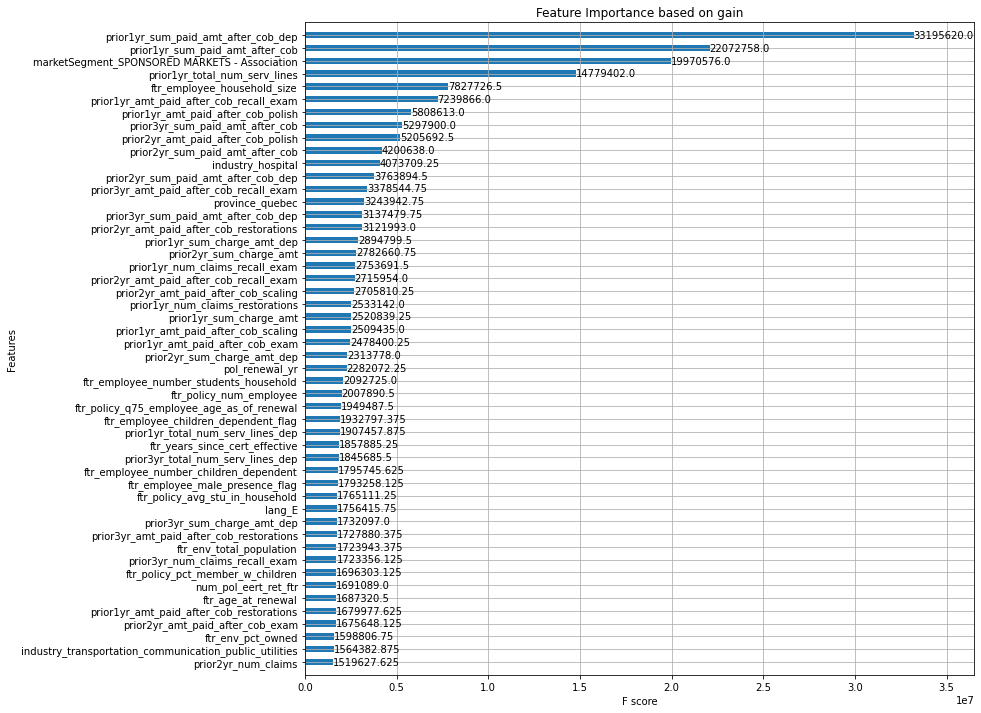

In [130]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)

plot_importance(model, max_num_features = 50, importance_type='gain', title='Feature Importance based on gain', height=.5)
plt.show()

In [122]:
# getting feature_importance data
feature_importance = model.get_booster().get_score(importance_type='gain')
# sorting descending based on the score
sorted(feature_importance.items(), key=lambda x:-x[1])

[('prior1yr_sum_paid_amt_after_cob_dep', 33195620.0),
 ('prior1yr_sum_paid_amt_after_cob', 22072758.0),
 ('marketSegment_SPONSORED MARKETS - Association', 19970576.0),
 ('prior1yr_total_num_serv_lines', 14779402.0),
 ('ftr_employee_household_size', 7827726.5),
 ('prior1yr_amt_paid_after_cob_recall_exam', 7239866.0),
 ('prior1yr_amt_paid_after_cob_polish', 5808613.0),
 ('prior3yr_sum_paid_amt_after_cob', 5297900.0),
 ('prior2yr_amt_paid_after_cob_polish', 5205692.5),
 ('prior2yr_sum_paid_amt_after_cob', 4200638.0),
 ('industry_hospital', 4073709.25),
 ('prior2yr_sum_paid_amt_after_cob_dep', 3763894.5),
 ('prior3yr_amt_paid_after_cob_recall_exam', 3378544.75),
 ('province_quebec', 3243942.75),
 ('prior3yr_sum_paid_amt_after_cob_dep', 3137479.75),
 ('prior2yr_amt_paid_after_cob_restorations', 3121993.0),
 ('prior1yr_sum_charge_amt_dep', 2894799.5),
 ('prior2yr_sum_charge_amt', 2782660.75),
 ('prior1yr_num_claims_recall_exam', 2753691.5),
 ('prior2yr_amt_paid_after_cob_recall_exam', 271595

#### Cross Validation

In [218]:
from sklearn.model_selection import KFold

model = XGBRegressor(random_state=seed)
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    
    #model = XGBRegressor(random_state=seed)
    model.fit(X_train, y_train)
    preds = model.predict(X_train)

    #print(model)
    print('forecast error (absolute): {}%'.format(round(abs(y_train - preds).sum() * 100 / y_train.sum(), 2)))
    print('forecast error (aggregate): {}%'.format(round((y_train - preds).sum() * 100 / y_train.sum(), 2)))
    print()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
forecast error (absolute): 19.69%
forecast error (aggregate): 0.05%

forecast error (absolute): 19.96%
forecast error (aggregate): 0.07%

forecast error (absolute): 19.77%
forecast error (aggregate): 0.04%

forecast error (absolute): 18.93%
forecast error (aggregate): 0.03%

forecast error (absolute): 19.73%
forecast error (a

In [126]:
# getting correlation of predictors with the target column
corr = data.corr()['target']
# sorting descending (absolute value) based on the correclation value
sorted(corr.items(), key=lambda x:-abs(x[1]))

[('target', 1.0),
 ('prior1yr_sum_paid_amt_after_cob', 0.5095499490962072),
 ('prior1yr_total_num_serv_lines', 0.49036350458775074),
 ('prior1yr_num_claims', 0.48442284784252243),
 ('prior1yr_sum_paid_amt_after_cob_dep', 0.47283266505466576),
 ('prior1yr_total_num_serv_lines_dep', 0.458963063857955),
 ('prior1yr_num_claims_dep', 0.45035888847595984),
 ('prior1yr_amt_paid_after_cob_recall_exam', 0.4389387293288658),
 ('prior2yr_sum_paid_amt_after_cob', 0.4050720143780497),
 ('prior2yr_total_num_serv_lines', 0.4009594190504877),
 ('prior1yr_num_claims_recall_exam', 0.40061386113699826),
 ('prior2yr_num_claims', 0.3989923231045751),
 ('ftr_employee_household_size', 0.3908298275397032),
 ('ftr_employee_number_dependents', 0.3895363608893624),
 ('prior2yr_total_num_serv_lines_dep', 0.38046981287438375),
 ('prior2yr_num_claims_dep', 0.37175919794804235),
 ('prior1yr_sum_charge_amt', 0.370489056142417),
 ('prior1yr_sum_charge_amt_dep', 0.36840869259011255),
 ('prior2yr_sum_paid_amt_after_cob_